# HSE 2021: Mathematical Methods for Data Analysis

## Homework 4

**Warning 1**: You have 2 weeks for this assignemnt.  **it is better to start early (!)**

**Warning 2**: it is critical to describe and explain what you are doing and why, use markdown cells


### Contents

#### Decision Trees - 7 points
* [Task 1](#task1) (0.5 points)
* [Task 2](#task2) (0.5 points)
* [Task 3](#task3) (2 points)
* [Task 4](#task4) (0.5 points)
* [Task 5](#task5) (0.5 points)
* [Task 6](#task6) (2 points)
* [Task 7](#task7) (0.5 points)
* [Task 8](#task8) (0.5 points)

#### Ensembles - 3 points
* [Task 1](#task2_1) (1 point)
* [Task 2](#task2_2) (0.7 points)
* [Task 3](#task2_3) (0.5 points)
* [Task 4](#task2_4) (0.7 points)
* [Task 5](#task2_5) (0.1 points)

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

plt.rcParams['figure.figsize'] = (11, 5)
%matplotlib inline

# Part 1. Decision Tree Regressor

In this task you will be implementing decision tree for the regression by hand.

### Task 1 <a id="task1"></a> (0.5 points)

Here you should implement the function `H()` which calculates impurity criterion. We will be training regression tree, and will take mean absolute deviation as impurity criterion.

* You cannot use loops
* If `y` is empty, the function should return 0

### Формула MAD:
$$\frac{1}{n}\sum_{i=1}^{n} |y_i - \bar{y}|$$

In [2]:
def H(y):
    """
    Calculate impurity criterion

    Parameters
    ----------
    y : np.array
        array of objects target values in the node

    Returns
    -------
    H(R) : float
        Impurity in the node (measuread by variance)
    """
    if len(y) == 0:
        return 0
    return np.mean(np.abs(y - np.mean(y)))

In [3]:
# Test the function
assert np.allclose(H(np.array([4, 2, 2, 2])), 0.75)
assert np.allclose(H(np.array([])), 0.0)

### Task 2 <a id="task2"></a>  (0.5 points)

To find the best split in the node we need to calculate the cost function. Denote:
- `R` all the object in the node
- `j` index of the feature selected for the split
- `t` threshold
- `R_l` and `R_r` objects in the left and right child nodes correspondingly

We get the following cost function:

$$
Q(R, j, t) =\frac{|R_\ell|}{|R|}H(R_\ell) + \frac{|R_r|}{|R|}H(R_r) \to \min_{j, t},
$$

Implement the function `Q`, which should calculate value of the cost function for a given feature and threshold.

In [4]:
def Q(X, y, j, t):
    """
    Calculate cost function
    Parameters
    ----------
    X : ndarray
        array of objects in the node
    y : ndarray
        array of target values in the node
    j : int
        feature index (column in X)
    t : float
        threshold

    Returns
    -------
    Q : float
        Value of the cost function
    """

    R_l = y[X[:, j] <= t]
    R_r = y[X[:, j] > t]

    size_R = len(y)
    size_R_l = len(R_l)
    size_R_r = len(R_r)

    H_R_l = H(R_l)
    H_R_r = H(R_r)

    return (size_R_l / size_R) * H_R_l + (size_R_r / size_R) * H_R_r

### Task 3 <a id="task3"></a>  (2 points)

Now, let's implement `MyDecisionTreeRegressor` class. More specifically, you need to implement the following methods:

- `best_split`
- `grow_tree`
- `get_prediction`

Also, please add `min_samples_leaf` parameter to your class

Read docstrings for more details. Do not forget to use function `Q` implemented above, when finding the `best_split`

In [5]:
class Node(object):
    """
    Class for a decision tree node.

    Parameters
    ----------
    right : Node() or None
        Right child
    left : Node() or None
        Left child
    threshold: float

    column: int

    depth: int

    samples: int

    prediction: float
        prediction of the target value in the node
        (average values calculated on a train dataset)
    is_terminal:bool
        indicates whether it is a terminal node (leaf) or not
    """
    def __init__(self):
        self.right = None
        self.left = None
        self.threshold = None
        self.column = None
        self.depth = None
        self.samples = None
        self.is_terminal = False
        self.prediction = None

    def __repr__(self):
        if self.is_terminal:
            node_desc = 'Pred: {:.2f}'.format(self.prediction)
        else:
            node_desc = 'Col {}, t {:.2f}, Pred: {:.2f}'. \
            format(self.column, self.threshold, self.prediction)
        return node_desc

In [6]:
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.utils.validation import check_X_y, check_array, check_is_fitted

class MyDecisionTreeRegressor(RegressorMixin, BaseEstimator):
    """
    Class for a Decision Tree Regressor.

    Parameters
    ----------
    max_depth : int
        Max depth of a decision tree.
    min_samples_split : int
        Minimal number of samples (objects) in a node to make a split.
    """
    def __init__(self, max_depth=3, min_samples_split=2, min_samples_leaf=1):
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.min_samples_leaf = min_samples_leaf

    def best_split(self, X, y):
        """
        Find the best split in terms of Q of data in a given decision tree node.
        Try all features and thresholds.

        Parameters
        ----------
        X : ndarray, shape (n_objects, n_features)
            Objects in the parent node
        y : ndarray, shape (n_objects, )
            1D array with the object labels.

        Returns
        -------
        best_split_column : int
            Index of the best split column
        best_threshold : float
            The best split condition.
        X_left : ndarray, shape (n_objects_l, n_features)
            Objects in the left child
        y_left : ndarray, shape (n_objects_l, )
            Objects labels in the left child.
        X_right : ndarray, shape (n_objects_r, n_features)
            Objects in the right child
        y_right : ndarray, shape (n_objects_r, )
            Objects labels in the right child.
        """

        # To store best split parameters
        best_split_column = None
        best_threshold = None

        best_cost = H(y)

        X_left = None
        y_left = None
        X_right = None
        y_right = None

        for column in range(X.shape[1]):
            feature_values = X[:, column]
            thresholds = np.unique(feature_values)

            for threshold in thresholds:
                # find best parameters that will have lowest cost function value
                cost = Q(X, y, column, threshold)
                if cost < best_cost:
                    # skip the split if one of the childs has less than minimum samples
                    if len(feature_values <= threshold) >= self.min_samples_leaf and len(feature_values > threshold) >= self.min_samples_leaf:
                      best_cost = cost
                      best_split_column = column
                      best_threshold = threshold
                      X_left = X[feature_values <= threshold]
                      y_left = y[feature_values <= threshold]
                      X_right = X[feature_values > threshold]
                      y_right = y[feature_values > threshold]

        return best_split_column, best_threshold, X_left, y_left, X_right, y_right

    def is_terminal(self, node, y):
        """
        Check terminality conditions based on `max_depth`,
        `min_samples_split` parameters for a given node.

        Parameters
        ----------
        node : Node,

        y : ndarray, shape (n_objects, )
            Object labels.

        Returns
        -------
        Is_termial : bool
            If True, node is terminal
        """
        if node.depth >= self.max_depth:
            return True
        if len(y) < self.min_samples_split:
            return True
        return False

    def grow_tree(self, node, X, y):
        """
        Reccurently grow the tree from the `node` using a `X` and `y` as a dataset:
         - check terminality conditions
         - find best split if node is not terminal
         - add child nodes to the node
         - call the function recursively for the added child nodes

        Parameters
        ----------
        node : Node() object
            Current node of the decision tree.
        X : ndarray, shape (n_objects, n_features)
            Objects
        y : ndarray, shape (n_objects)
            Labels
        """

        if self.is_terminal(node, y):
            node.is_terminal =True
            return

        best_split_column, best_threshold, X_left, y_left, X_right, y_right = self.best_split(X, y)

        # Write data into child nodes and run grow recursively
        if best_split_column is not None:
            node.column = best_split_column
            node.threshold = best_threshold

            node.left = Node()
            node.right = Node()

            node.left.depth = node.depth + 1
            node.right.depth = node.depth + 1

            node.left.prediction = np.mean(y_left)
            node.right.prediction = np.mean(y_right)

            node.left.samples = X_left.shape[0]
            node.right.samples = X_right.shape[0]

            self.grow_tree(node.left, X_left, y_left)
            self.grow_tree(node.right, X_right, y_right)
        else:
            node.is_terminal = True


    def fit(self, X, y):
        """
        Fit the Decision Tree Regressor.

        Parameters
        ----------
        X : ndarray, shape (n_samples, n_features)
            The input samples.
        y : ndarray, shape (n_samples,) or (n_samples, n_outputs)
            The target values.
        Returns
        -------
        self : object
            Returns self.
        """
        X, y = check_X_y(X, y, accept_sparse=False)
        self.is_fitted_ = True

        # Initialize and grow the tree
        self.tree_ = Node()
        self.tree_.depth = 1
        self.tree_.prediction = np.mean(y)
        self.tree_.samples = X.shape[0]

        self.grow_tree(self.tree_, X, y)

        # needed to make check estimator work properly
        self.n_features_ = X.shape[1]
        self.n_features_in_ = X.shape[1]

        return self

    def get_prediction(self, node, x):
        """
        Get prediction for an object `x`
            - Return prediction of the `node` if it is terminal
            - Otherwise, recursively call the function to get
            predictions of the proper child

        Parameters
        ----------
        node : Node() object
            Current node of the decision tree.
        x : ndarray, shape (n_features,)
            Array of feature values of one object.
        Returns
        -------
        y_pred : float
            Prediction for an object x
        """
        if node.is_terminal:
            return node.prediction

        if x[node.column] <= node.threshold:
            return self.get_prediction(node.left, x)
        else:
            return self.get_prediction(node.right, x)

    def predict(self, X):
        """
        Get prediction for each object in X

        Parameters
        ----------
        X : ndarray, shape (n_samples, n_features)
            The input samples.
        Returns
        -------
        y : ndarray, shape (n_samples,)
            Returns predictions.
        """
        # Check input and that `fit` had been called
        X = check_array(X, accept_sparse=False)
        check_is_fitted(self, 'is_fitted_')

        # Get predictions
        y_predicted = []
        for x in X:
            y_curr = self.get_prediction(self.tree_, x)
            y_predicted.append(y_curr)
        return np.array(y_predicted)

In [7]:
# check yourself
from sklearn.utils.estimator_checks import check_estimator

check_estimator(MyDecisionTreeRegressor())

### Task 4 <a id="task4"></a>  (0.5 points)

Load boston dataset and split it on the train ($75\%$) and test ($25\%$). Fit Decision Tree of **depth 1, 3, 5** and make the following plots for every case:

- Scatter plot of the traning points (selected for split feature on the x-axis, target variable on the y-axis)
- Fitted model (tree visualization)

Compare `MAE` on train and test. Have trees overfitted?

In [8]:
from sklearn.model_selection import train_test_split

# Load the Boston dataset
data_url = "http://lib.stat.cmu.edu/datasets/boston"
dataset = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
X = np.hstack([dataset.values[::2, :], dataset.values[1::2, :2]])
y = dataset.values[1::2, 2]

# Split the dataset into train and test sets (75% train, 25% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [9]:
depths = [1, 3, 5]
models = {}
for depth in depths:
    model = MyDecisionTreeRegressor(max_depth=depth)
    model.fit(X_train, y_train)
    models[depth] = model

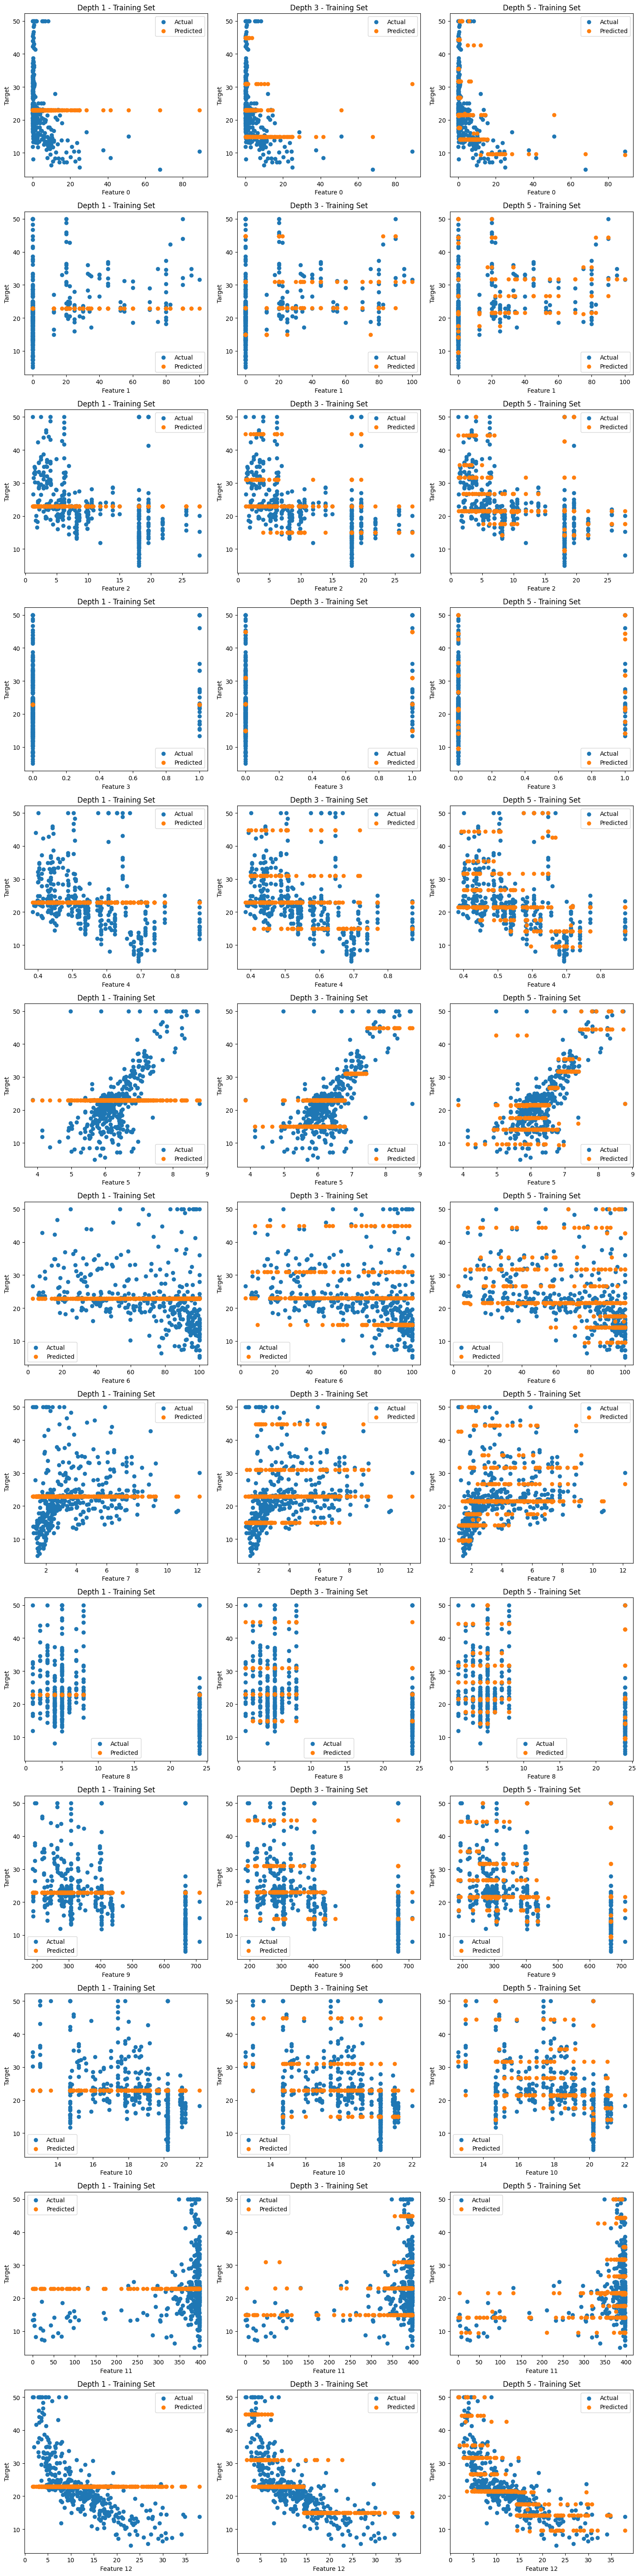

In [10]:
from sklearn.tree import plot_tree, export_graphviz
from sklearn.metrics import mean_absolute_error

fig, axes = plt.subplots(nrows=X_train.shape[1], ncols=len(depths), figsize=(15, 60))

for feature_index in range(X_train.shape[1]):
    for i, depth in enumerate(depths, 0):
      ax = axes[feature_index][i]
      model = models[depth]
      # Get predictions on the training data
      y_pred_train = model.predict(X_train)
      ax.scatter(X_train[:, feature_index], y_train, label='Actual')
      ax.scatter(X_train[:, feature_index], y_pred_train, label='Predicted')
      ax.set_xlabel(f'Feature {feature_index}')
      ax.set_ylabel('Target')
      ax.set_title(f"Depth {depth} - Training Set")
      ax.legend()
plt.tight_layout()
plt.show()

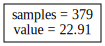

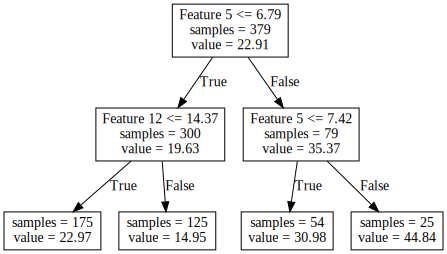

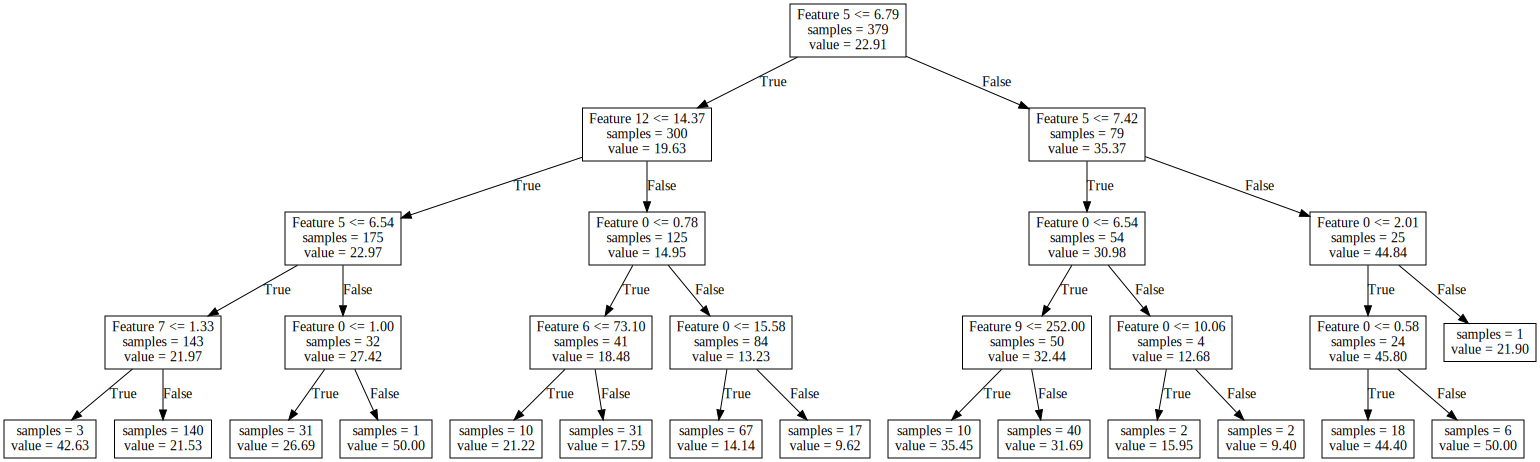

In [11]:
from graphviz import Digraph
def build_tree_dot(tree, feature_names, dot):
    if tree.is_terminal:
        dot.node(str(id(tree)), label=f"samples = {tree.samples}\nvalue = {tree.prediction:.2f}")
    else:
        dot.node(str(id(tree)), label=f"Feature {feature_names[tree.column]} <= {tree.threshold:.2f}\nsamples = {tree.samples}\nvalue = {tree.prediction:.2f}")
        build_tree_dot(tree.left, feature_names, dot)
        build_tree_dot(tree.right, feature_names, dot)
        dot.edge(str(id(tree)), str(id(tree.left)), label='True')
        dot.edge(str(id(tree)), str(id(tree.right)), label='False')

def visualize_tree(tree, feature_names):
    dot = Digraph()
    dot.attr('node', shape='box')
    build_tree_dot(tree, feature_names, dot)
    return dot

for depth in depths:
    model = models[depth]
    tree_viz = visualize_tree(model.tree_, list(range(X.shape[1])))
    display(tree_viz)


In [12]:
for depth in depths:
    model = models[depth]
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)
    mae_train = mean_absolute_error(y_train, y_pred_train)
    mae_test = mean_absolute_error(y_test, y_pred_test)
    print(f"Depth {depth}: MAE on train set - {mae_train:.2f}, MAE on test set - {mae_test:.2f}")

Depth 1: MAE on train set - 6.89, MAE on test set - 6.22
Depth 3: MAE on train set - 3.51, MAE on test set - 3.53
Depth 5: MAE on train set - 2.37, MAE on test set - 3.05


### Анализ полученных результатов
Мы видим, что при всех значениях максимальной глубины дерева, как на тренировочных данных, так и на тестовых данных метрика MAE снижается, что показывает положительную динамику и говорит об отсутствии на данной стадии переобучения у модели. Стоит отметить, что для всех значений глубины кроме 1 результаты на обучающей выборке были лучше, что логично, ведь модель тренировалась на этих данных. На глубине 1 же не смогли сформироваться нужные зависимости, и поэтому мы видим такой результат.

### Task 5 <a id="task5"></a>  (0.5 points)

Keep working with boston dataset.
- Use `GridSearchCV` to find the best hyperparameters among [`max_depth`, `min_samples_leaf`] on 5-Fold cross-validation
- Train the model with the best set of hyperparameters on the whole train dataset.
- Report `MAE` on test dataset and hyperparameters of the best estimator.

In [13]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'max_depth': [3, 5, 7, 9, 11],
    'min_samples_leaf': [1, 2, 4, 6, 8, 10]
}

model = MyDecisionTreeRegressor()

# GridSearchCV to find the best hyperparameters using 5-Fold cross-validation
grid_search = GridSearchCV(model, param_grid, cv=5, scoring='neg_mean_absolute_error', n_jobs=-1)
grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
best_estimator = grid_search.best_estimator_

# Train model with best hyperparameters on whole dataset
best_estimator.fit(X_train, y_train)

y_pred = best_estimator.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)

print(f"MAE on test dataset: {mae}")
print("Best hyperparameters:")
for param, value in best_params.items():
    print(f"{param}: {value}")

MAE on test dataset: 3.0179471250472694
Best hyperparameters:
max_depth: 7
min_samples_leaf: 10


### Task 6 <a id="task6"></a>  (2 points)

Recall definition of bias and variance:
$$
\text{Bias}^2 = \mathbb{E}_{p(x, y)} \left[  (f(x) - \mathbb{E}_{\mathbb{X}}a_{\mathbb{X}}(x))^2 \right] \\
\text{Variance} = \mathbb{E}_{p(x, y)} \left[  \mathbb{V}_{\mathbb{X}}( a_{\mathbb{X}}(x))  \right]
$$

We wil now use the following algorithm to estimate bias and variance:

1. Use bootsrap to create `n_iter` samples from the original dataset: $X_1, \dots, X_{n_iter}$
2. For each bootstrapped sample define out-of-bag (OOB) sample $Z_1, \dots, Z_{n_iter}$, which contain all the observations, which did not appear in the corresponding boostraped sample
3. Fit the model on $X_i$s and compute predictions on $Z_i$s
4. For a given *object* $n$:
     - bias^2: squared difference between true value $y_n$ and average prediction (average over the algorithms, for which $n$ was in OOB)
     - variance: variance of the prediction (predictions of the algorithms, for which $n$ was in OOB)
5. Average bias^2 and variance over all the points
    
**Implement `get_bias_variance` function, using the algorithm above**

*Note:*  You can only use 1 loop (for bootsrap iterations). All other operations should be vectorized.

In [14]:
def get_bias_variance(estimator, X, y, n_iter, random_state=37):
    """
    Calculate bias and variance of the `estimator`.
    Using a given dataset and bootstrap with `n_iter` samples.

    Parameters
    ----------
    x : ndarray, shape (n_samples, n_features)
        The input samples.
    y : ndarray, shape (n_samples, n_features)
        The input samples.
    n_iter: int
        Number of samples in
    Returns
    -------
    bias2 : float,
        Estiamted squared bias
    variance : float,
        Estiamted variance
    """

    n_samples = X.shape[0]
    predictions = np.full((n_samples, n_iter), np.nan)
    np.random.seed(random_state)

    for i in range(n_iter):
        # Generate bootstrap samples, fit model with them
        bootstrap_indexes = np.random.choice(n_samples, size=n_samples, replace=True)
        x_bootstrap = X[bootstrap_indexes]
        y_bootstrap = y[bootstrap_indexes]

        estimator.fit(x_bootstrap, y_bootstrap)

        # Create out-of-bag samples, model predict
        oob_indexes = np.setdiff1d(np.arange(n_samples), bootstrap_indexes, assume_unique=True)

        predictions[oob_indexes, i] = estimator.predict(X[oob_indexes])

    valid_preds = ~np.isnan(predictions).all(axis=1)

    # Calculate bias squared
    bias_squared = np.mean((np.nanmean(predictions[valid_preds], axis=1) - y[valid_preds]) ** 2)

    # Calculate variance
    variance = np.mean(np.nanvar(predictions[valid_preds], axis=1))

    return bias_squared, variance

In [15]:
# Test
estimator = MyDecisionTreeRegressor(max_depth=8, min_samples_split=15)

get_bias_variance(estimator, X_train, y_train, 10)

(17.026586874385472, 8.36436199957533)

### Task 7 <a id="task7"></a>  (0.5 points)

Compute bias and variance for the trees with different min_samples_split. Plot how bias and variance change as min_samples_split increases.

Comment on what you observe, how does your result correspond to theory?

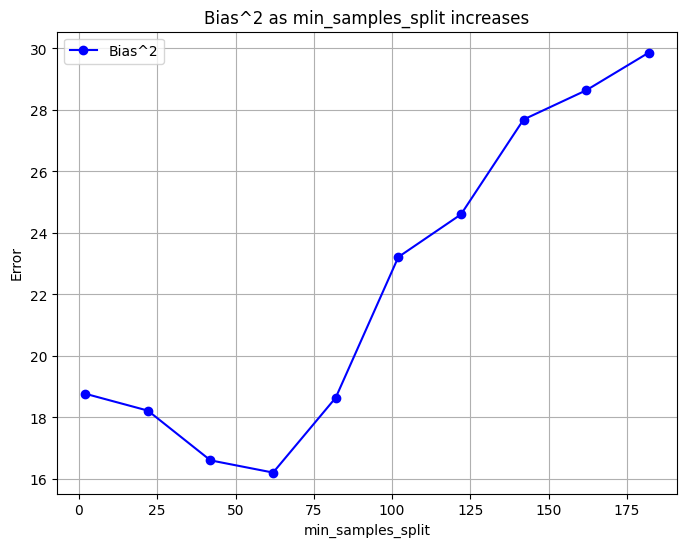

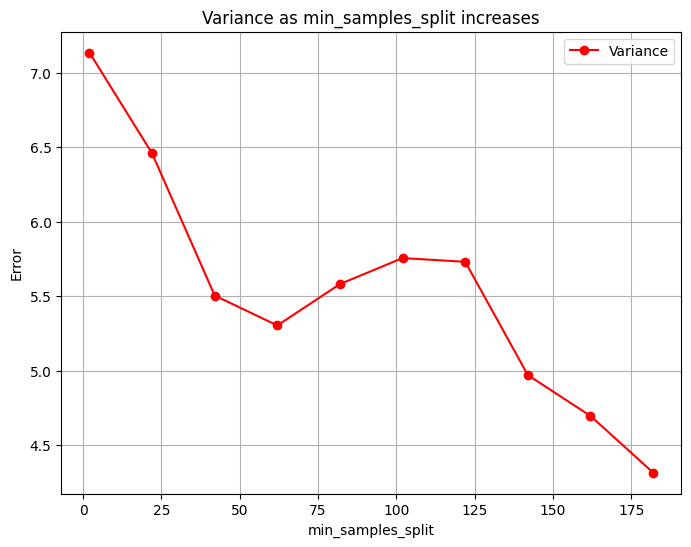

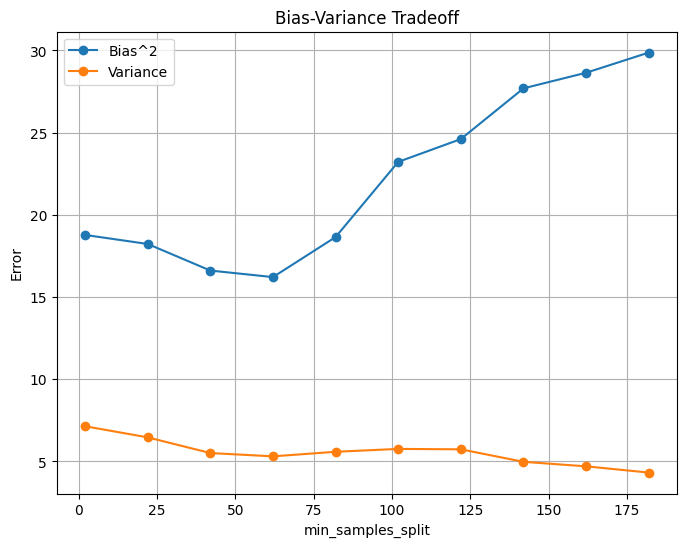

In [16]:
min_samples_splits = np.arange(2, 200, 20)

# Calculate bias and variance for each min_samples_split value
biases = []
variances = []

for min_samples in min_samples_splits:
    estimator = MyDecisionTreeRegressor(max_depth=8, min_samples_split=min_samples)
    bias, variance = get_bias_variance(estimator, X, y, 10)
    biases.append(bias)
    variances.append(variance)

# Plot bias squared
plt.figure(figsize=(8, 6))
plt.plot(min_samples_splits, biases, label='Bias^2', marker='o', color='blue')
plt.xlabel('min_samples_split')
plt.ylabel('Error')
plt.title('Bias^2 as min_samples_split increases')
plt.legend()
plt.grid(True)
plt.show()

# Plot variance
plt.figure(figsize=(8, 6))
plt.plot(min_samples_splits, variances, label='Variance', marker='o', color='red')
plt.xlabel('min_samples_split')
plt.ylabel('Error')
plt.title('Variance as min_samples_split increases')
plt.legend()
plt.grid(True)
plt.show()

# Plot bias and variance as min_samples_split changes
plt.figure(figsize=(8, 6))
plt.plot(min_samples_splits, biases, label='Bias^2', marker='o')
plt.plot(min_samples_splits, variances, label='Variance', marker='o')
plt.xlabel('min_samples_split')
plt.ylabel('Error')
plt.title('Bias-Variance Tradeoff')
plt.legend()
plt.grid(True)
plt.show()

### Анализ полученных результатов
На графиках видно, что по мере увеличения количества min_samples_split показатели ошибок у обоих метрик снижается примерно до момента достижения точки 42. После чего bias начинает увеличиваться, а variance демонстрирует колебания и понемногу снижается. Повышенное значение метрики variance сообщает о переобучении модели, а bias о недообученности. Можно сказать, что переобучение может возникнуть при сильном увеличении глубины дерева, а недообучение, когда мы увеличиваем количество семплов необходимых для разделения ноды, что не дает сформироваться всем необходимым связям в модели, особенно если данных не много. что мы сейчас как раз и делаем. Поскольку мы именно увеличивали минимальное количество семплов для разделения, то метрика bias показывает предсказуемый результат, с определенного момента начиная стремительно уходить вверх.



### Task 8 <a id="task8"></a>  (0.5 points)

Let's try to reduce variance with bagging. Use `sklearn.ensemble.BaggingRegressor` to get an ensemble and compute its bias and variance.

Answer the following questions:
 - How bagging should affect bias and variance in theory?
 - How bias and variance change (if they change) compared to an individual tree in you experiments?
 - Do your results align with the theory? Why?

In [17]:
from sklearn.ensemble import BaggingRegressor

# Define a Decision Tree regressor and a Bagging ensemble
tree = MyDecisionTreeRegressor(max_depth=8, min_samples_split=15)
bagging = BaggingRegressor(estimator=tree, n_estimators=10, random_state=37)

# Calculate bias and variance for the individual tree
tree_bias, tree_variance = get_bias_variance(tree, X_train, y_train, 10)

# Calculate bias and variance for the Bagging ensemble
bagging_bias, bagging_variance = get_bias_variance(bagging, X_train, y_train, 10)

print(f"Individual Tree - Bias^2: {tree_bias:.4f}, Variance: {tree_variance:.4f}")
print(f"Bagging Ensemble - Bias^2: {bagging_bias:.4f}, Variance: {bagging_variance:.4f}")

Individual Tree - Bias^2: 17.0266, Variance: 8.3644
Bagging Ensemble - Bias^2: 16.5463, Variance: 2.5345


### Анализ полученных результатов
В теории bagging направлен в первую очередь на снижение ошибки variance, при этом не влияя на bias. Однако смотря на результаты мы видим, что variance действительно значительно снизился, но в дополнении к этому еще и немного понизился показатель bias. Такое могло произойти из-за усреднения по результатам нескольких моделей. Множество моделей могут лучше описывать различные признаки из-за чего после усреднения помимо variance также может незначительно измениться bias, как произошло в нашем случае.

# Part 2. More Ensembles

In this part we will be working with [Billionaires Statistics Dataset](https://www.kaggle.com/datasets/nelgiriyewithana/billionaires-statistics-dataset) to solve a classification task.

In [19]:
from sklearn.preprocessing import LabelEncoder

df = pd.read_csv('Billionaires Statistics Dataset.csv')

le = LabelEncoder()
y = le.fit_transform(df['selfMade'])
X = df.drop('selfMade', axis=1)
X.head(5)

,rank,finalWorth,category,personName,age,country,city,source,industries,countryOfCitizenship,...,cpi_change_country,gdp_country,gross_tertiary_education_enrollment,gross_primary_education_enrollment_country,life_expectancy_country,tax_revenue_country_country,total_tax_rate_country,population_country,latitude_country,longitude_country
0,1,211000,Fashion & Retail,Bernard Arnault & family,74.0,France,Paris,LVMH,Fashion & Retail,France,...,1.1,"$2,715,518,274,227",65.6,102.5,82.5,24.2,60.7,67059887.0,46.227638,2.213749
1,2,180000,Automotive,Elon Musk,51.0,United States,Austin,"Tesla, SpaceX",Automotive,United States,...,7.5,"$21,427,700,000,000",88.2,101.8,78.5,9.6,36.6,328239523.0,37.090240,-95.712891
2,3,114000,Technology,Jeff Bezos,59.0,United States,Medina,Amazon,Technology,United States,...,7.5,"$21,427,700,000,000",88.2,101.8,78.5,9.6,36.6,328239523.0,37.090240,-95.712891
3,4,107000,Technology,Larry Ellison,78.0,United States,Lanai,Oracle,Technology,United States,...,7.5,"$21,427,700,000,000",88.2,101.8,78.5,9.6,36.6,328239523.0,37.090240,-95.712891
4,5,106000,Finance & Investments,Warren Buffett,92.0,United States,Omaha,Berkshire Hathaway,Finance & Investments,United States,...,7.5,"$21,427,700,000,000",88.2,101.8,78.5,9.6,36.6,328239523.0,37.090240,-95.712891


### Task 1 <a id="task2_1"></a> (1 point)

Let's start with data preprocessing.

0. Drop columns, which are not usefull (e.g. a lot of missing values). Motivate your choice.
1. Split dataset into train and test
2. You've probably noticed that we have both categorical and numerical columns. Here is what you need to do with them:
    - Categorical: Fill missing values and apply one-hot-encoding (if there are many unique values in a column, you can group them by meaning)
    - Numeric: Fill missing values
    
Use `ColumnTranformer` to define a single transformer for all the columns in the dataset. It takes as input a list of tuples

```
ColumnTransformer([
    ('name1', transform1, column_names1),
    ('name2', transform2, column_names2)
])
```

Pay attention to an argument `remainder='passthrough'`. [Here](https://scikit-learn.org/stable/modules/compose.html#column-transformer) you can find some examples of how to use column transformer.
    
Since we want to apply 2 transformations to categorical feature, it is very convenient to combine them into a `Pipeline`:

```
double_tranform = make_pipeline(
                        transform_1,
                        transform_2
                        )
```

P.S. Choose your favourite way to fill missing values.

*Hint* Categorical column usually have `dtype = 'object'`. This may help to obtain list of categorical and numerical columns on the dataset.

In [20]:
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer

# Drop columns with 20% of missing values
threshold = 0.80
X = X.dropna(thresh=threshold * len(df.values), axis=1)

# Drop columns that contain not very useful for training or repeated data
X = X.drop(['personName', 'lastName', 'firstName', 'date', 'birthDate', 'birthMonth', 'birthDay'], axis=1)

# Split dataset into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# Identify categorical and numerical columns
categorical_cols = X.select_dtypes(include=['object']).columns
numerical_cols = X.select_dtypes(exclude=['object']).columns

# Define transformers for numerical and categorical columns
numeric_transformer = SimpleImputer(strategy='mean')
categorical_transformer = make_pipeline(
    SimpleImputer(strategy='most_frequent'),
    OneHotEncoder(handle_unknown='ignore')
)

# Create ColumnTransformer
column_transformer = ColumnTransformer(
    transformers=[
        ('numeric', numeric_transformer, numerical_cols),
        ('categorical', categorical_transformer, categorical_cols)
    ],
    remainder='passthrough'
)

# Transform the data
X_train = column_transformer.fit_transform(X_train)
X_test = column_transformer.transform(X_test)

### Пояснение
При подготовке данных были отброшены признаки, имеющие более 20% пропущенных значений, поскольку 20-25% считается той границей, после которой происходит сильная потеря данных для обучения по этому признаку.

Также уберем следующие признаки: 'personName', 'lastName', 'firstName', 'date', 'birthDate', 'birthMonth', 'birthDay', поскольку я считаю, что ФИО человека и дата представленная в date никак не влияет на таргет переменную. Нас так же не сильно интересует месяц и день рождения, достаточно будет только года, поэтому уберем дублирующую и излишнюю информацию.

Пропуски категориальных признаков заполнялись по принципу наиболее встречаемые и кодировались с помощью OneHotEncoding. Пропуски числовых признаков заполнялись по принципу среднего значения.

### Task 2 <a id="task2_2"></a> (0.7 points)

Fit and compare 5 different models (use sklearn): Gradient Boosting, Random Forest, Decision Tree, SVM, Logitics Regression
    
* Choose one classification metric and justify your choice .
* Compare the models using score on cross validation. Mind the class balance when choosing the cross validation. (You can read more about different CV strategies [here](https://scikit-learn.org/stable/modules/cross_validation.html#stratified-k-fold))
* Which model has the best performance? Which models overfit or underfit?

In [36]:
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import make_scorer, f1_score
from collections import defaultdict

print(f"Class Balance:\n{df.groupby('selfMade')['selfMade'].count()}\n")

np.random.seed(42)

models = {
    'Gradient Boosting': GradientBoostingClassifier(),
    'Random Forest': RandomForestClassifier(),
    'Decision Tree': DecisionTreeClassifier(),
    'SVM': SVC(),
    'Logistic Regression': LogisticRegression()
}


scorer = make_scorer(f1_score)

# Initialize cross-validation strategy with consideration for class imbalance
cv = StratifiedKFold(n_splits=5, shuffle=True)

f1_scores = defaultdict(list)

results = {}

# Fit models and perform cross-validation
for model_name, model in models.items():
    scores = cross_val_score(model, X_train, y_train, cv=cv, scoring=scorer)
    f1_scores[model_name].extend(scores)

for model_name, scores in f1_scores.items():
    avg_f1_score = sum(scores) / len(scores)
    results[model_name] = avg_f1_score
    print(f'{model_name}: Average F1-score - {avg_f1_score:.4f}, Variance - {np.var(scores)}')

Class Balance:
selfMade
False     828
True     1812
Name: selfMade, dtype: int64

Gradient Boosting: Average F1-score - 0.8633, Variance - 0.0001580972015554045
Random Forest: Average F1-score - 0.8730, Variance - 4.227336253032741e-05
Decision Tree: Average F1-score - 0.8356, Variance - 0.00012334976448547064
SVM: Average F1-score - 0.8161, Variance - 1.232595164407831e-32
Logistic Regression: Average F1-score - 0.8161, Variance - 1.232595164407831e-32


### Анализ полученных данных
Перед выбором проанализируем баланс классов. Видим что есть довольно сильный перевес в сторону True. В связи с этим в качестве метрики оценивания будем использовать f1-score, которая включает в себя и precision и recall, а потому будет хорошо подходить для нашей задачи.

По той же причине в качестве кросс валидации мы возьмем StratifiedKFold, который лучше остальных справляется при дисбалансе классов.

По результатам метрик мы видим, что лучший показателем обладает модель на базе Random Forest. В то же время у всех моделей довольно низкий variance, и высокий f1-score, что говорит о том, что у нас не наблюдается переобучения или недообучения.

В целом наиболее плохие результаты показали SVM и LinReg, чуть лучше DT, значительно лучше GB и лучше всех - RF.

### Task 3 <a id="task2_3"></a> (0.5 points)

More Gradient Boosting. You will have to take one of the three popular boosting implementations (xgboost, lightgbm, catboost). Select hyperparameters (number of trees, learning rate, depth) on cross-validation and compare with the methods from the previous task.

In [25]:
import xgboost as xgb
from sklearn.model_selection import GridSearchCV

np.random.seed(42)

xgb_model = xgb.XGBClassifier()

param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.3],
    'max_depth': [2, 3, 4]
}

scorer = make_scorer(f1_score)

# Initialize cross-validation strategy with consideration for class imbalance
cv = StratifiedKFold(n_splits=5, shuffle=True)

# Perform Grid Search to find the best hyperparameters
grid_search = GridSearchCV(xgb_model, param_grid, cv=cv, scoring=scorer)
grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
print("Best Hyperparameters:", best_params)

# Calculate the average F1-score with the best model
best_model = grid_search.best_estimator_
xgb_scores = cross_val_score(best_model, X_train, y_train, cv=cv, scoring=scorer)
avg_xgb_f1_score = sum(xgb_scores) / len(xgb_scores)
results["XGBoost"] = avg_xgb_f1_score
print(f'XGBoost: Average F1-score - {avg_xgb_f1_score:.4f}')

Best Hyperparameters: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100}
XGBoost: Average F1-score - 0.8645


### Анализ полученных результатов
Для этого задания была выбрана реализация xgboost. Модель с лучшими гиперпараметрами показала конкурентоспособные результаты с моделями из предыдущего номера. Она справилась заметно лучше LinReg, SVM и DT, чуть лучше GB и немного хуже RF.

### Task 4 <a id="task2_4"></a> (0.7 points)

Now let's train more fancy ensembles:

* Bagging with decision trees as base estimators
* Bagging with gradient boosting (with large amount of trees, >100) as base estimators
* [Voting classifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.VotingClassifier.html#sklearn.ensemble.VotingClassifier)
* [Stacking Classifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.StackingClassifier.html#sklearn.ensemble.StackingClassifier) with Logistic Regression as a final model
* [Stacking Classifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.StackingClassifier.html#sklearn.ensemble.StackingClassifier) with Gradeint Boosting as a final model


If not stated in the task, feel free to tune / choose hyperparameters and base models.

Answer the questions:
* Which model has the best performance?
* Does bagging reduce overfiting of the gradient boosting with large amount of trees?
* What is the difference between voting and staking?

In [37]:
from sklearn.ensemble import BaggingClassifier, VotingClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression

estimators = [('decision_tree', DecisionTreeClassifier()), ('random_forest', RandomForestClassifier()), ('svm', SVC())]

np.random.seed(42)

models = {
    'bagging_dt': BaggingClassifier(estimator=DecisionTreeClassifier(), n_estimators=10),
    'bagging_gb': BaggingClassifier(estimator=GradientBoostingClassifier(n_estimators=200), n_estimators=10),
    'voting_classifier': VotingClassifier(estimators=estimators, voting='hard'),
    'stacking_lr': StackingClassifier(estimators=estimators, final_estimator=LogisticRegression()),
    'stacking_gb': StackingClassifier(estimators=estimators, final_estimator=GradientBoostingClassifier())
}

scorer = make_scorer(f1_score)

# Initialize cross-validation strategy with consideration for class imbalance
cv = StratifiedKFold(n_splits=5, shuffle=True)

f1_scores = defaultdict(list)

# Fit models and perform cross-validation
for model_name, model in models.items():
    scores = cross_val_score(model, X_train, y_train, cv=cv, scoring=scorer)
    f1_scores[model_name].extend(scores)

for model_name, scores in f1_scores.items():
    avg_f1_score = sum(scores) / len(scores)
    results[model_name] = avg_f1_score
    print(f'{model_name}: Average F1-score - {avg_f1_score:.4f}')

bagging_dt: Average F1-score - 0.8572
bagging_gb: Average F1-score - 0.8698
voting_classifier: Average F1-score - 0.8723
stacking_lr: Average F1-score - 0.8678
stacking_gb: Average F1-score - 0.8591


### Анализ полученных данных
В данном задании лучше всего себя показал voting classifier, однако стоит отметить, что метрики всех моделей довольно хороши и превышают показатели, например, LinReg, SVM и DT из 2 задания, что доказывает повышенную эффективность таких ансамблей.

Bagging уменьшает переобучение GB, поскольку он тренирует множество моделей на различных семплах данных и за счет повышения случайности GB с большим количеством деревьев менее склонен к переобучению.

Stacking classifier - ансамбль, который обучает последнюю модель на базе предсказаний уже обученных моделей. Комбинируя пресказания нескольких моделей, финальная модель учится делать итоговое предсказания для входных данных.

Voting classifier - ансамбль, который использует предсказания всех уже обученных моделей и выбирает нужный класс по принципу большинства голосов за определенный из них.

### Task 5 <a id="task2_5"></a> (0.1 points)

Report the test score for the best model, that you were able to train.

### Пояснения
Проанализировав все полученные результаты, можно сказать,что лучше всех справились voting classifier и RF, у них крайне близкие показатели, но RF на несколько тысячных долей все же лучше, так что выведем его результат.

In [42]:
model_name = 'Random Forest'
print(f'{model_name}: Average F1-score - {results[model_name]:.4f}')

Random Forest: Average F1-score - 0.8730
